In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random

class GridWorld:
    ACTIONS = {
        0: (-1, 0),  # UP
        1: (1, 0),   # DOWN
        2: (0, -1),  # LEFT
        3: (0, 1)    # RIGHT
    }
    ACTION_NAMES = {0: "UP", 1: "DOWN", 2: "LEFT", 3: "RIGHT"}
    ACTION_ARROWS = {0: "↑", 1: "↓", 2: "←", 3: "→"}

    def __init__(self, height=5, width=5, start=(0, 0), goal=(4, 4), step_penalty=-1, goal_reward=5, gamma=0.8):
        self.height = height
        self.width = width
        self.start = start
        self.goal = goal
        self.step_penalty = step_penalty
        self.goal_reward = goal_reward
        self.gamma = gamma

    def state_index(self, row, col):
        return row * self.width + col

    def state_coords(self, state):
        return divmod(state, self.width)

    def random_policy(self):
        policy = {}
        for s in range(self.width * self.height):
            policy[s] = {a: 1.0 / len(self.ACTIONS) for a in self.ACTIONS}
        return policy

    def reward(self, state):
        row, col = self.state_coords(state)
        return self.goal_reward if (row, col) == self.goal else self.step_penalty

    def step(self, state, action):
        row, col = self.state_coords(state)
        dr, dc = self.ACTIONS[action]

        nr, nc = row + dr, col + dc
        nr = max(0, min(self.height - 1, nr))
        nc = max(0, min(self.width - 1, nc))

        next_state = self.state_index(nr, nc)
        reward = self.reward(next_state)
        done = (nr, nc) == self.goal
        return next_state, reward, done

    def deterministic_policy(self, stochastic_policy):
        policy = {}
        rewards = {}

        for s in range(self.width * self.height):
            max_prob = max(stochastic_policy[s].values())
            best_actions = [a for a, p in stochastic_policy[s].items() if abs(p - max_prob) < 1e-8]
            chosen_action = random.choice(best_actions)
            policy[s] = {a: 1.0 if a == chosen_action else 0.0 for a in self.ACTIONS}
            rewards[s] = self.reward(s)

        return policy, rewards

    def run_episode(self, policy, max_steps=50):
        state = self.state_index(*self.start)
        trajectory = [state]
        rewards = [0]   # discounted returns
        total_reward = 0
        discount = 1.0

        for _ in range(max_steps):
            # Pick greedy action
            action = max(policy[state], key=policy[state].get)
            next_state, r, done = self.step(state, action)

            # Apply discount factor
            total_reward += discount * r
            discount *= self.gamma

            trajectory.append(next_state)
            rewards.append(total_reward)

            state = next_state
            if done:
                break

        return trajectory, rewards


    def visualise_episode(self, policy, cols=5):
        """Static plots of agent moving step by step in a row/column grid layout."""
        trajectory, rewards = self.run_episode(policy)
        n_steps = len(trajectory)

        rows = (n_steps + cols - 1) // cols  # ceil division
        fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 3*rows))

        # Flatten axes for easy iteration
        axes = axes.flatten() if isinstance(axes, (list, np.ndarray)) else [axes]

        for i in range(n_steps):
            ax = axes[i]
            # Draw grid
            for x in range(self.width + 1):
                ax.plot([x, x], [0, self.height], color="black")
            for y in range(self.height + 1):
                ax.plot([0, self.width], [y, y], color="black")

            # Mark start & goal
            sr, sc = self.start
            gr, gc = self.goal
            ax.text(sc + 0.5, self.height - sr - 0.5, "S", ha="center", va="center",
                    fontsize=14, color="blue", fontweight="bold")
            ax.text(gc + 0.5, self.height - gr - 0.5, "T", ha="center", va="center",
                    fontsize=14, color="green", fontweight="bold")

            # Mark agent
            row, col = self.state_coords(trajectory[i])
            ax.plot(col + 0.5, self.height - row - 0.5, "ro", markersize=12)

            # Title with step and cumulative reward
            ax.set_title(f"Step {i}\nReward={rewards[i]:.1f}")

            ax.set_xlim(0, self.width)
            ax.set_ylim(0, self.height)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_aspect("equal")

        # Hide unused subplots
        for j in range(n_steps, len(axes)):
            axes[j].axis("off")

        plt.tight_layout()
        plt.show()

    def visualise_policy(self, policy, title="Policy"):
        """Show the deterministic/stochastic policy with arrows in the grid."""
        fig, ax = plt.subplots(figsize=(self.width, self.height))

        # Draw grid
        for x in range(self.width + 1):
            ax.plot([x, x], [0, self.height], color="black")
        for y in range(self.height + 1):
            ax.plot([0, self.width], [y, y], color="black")

        for row in range(self.height):
            for col in range(self.width):
                s = self.state_index(row, col)
                x, y = col + 0.5, self.height - row - 0.5

                if (row, col) == self.goal:
                    ax.text(x, y, "T", ha="center", va="center", fontsize=16,
                            color="green", fontweight="bold")
                else:
                    # Best actions
                    max_prob = max(policy[s].values())
                    best_actions = [a for a, p in policy[s].items() if abs(p - max_prob) < 1e-8]

                    arrows = "".join([self.ACTION_ARROWS[a] for a in best_actions])
                    ax.text(x, y, arrows, ha="center", va="center", fontsize=14, color="red")

        ax.set_xlim(0, self.width)
        ax.set_ylim(0, self.height)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect("equal")
        ax.set_title(title, fontsize=14)
        plt.show()

    def value_iteration(self, theta=1e-6):
        """
        Perform value iteration for this GridWorld.
        Returns:
            V (dict): state -> value
            policy (dict): state -> {action: prob}
        """
        n_states = self.width * self.height
        V = {s: 0.0 for s in range(n_states)}  # init values
        policy = self.random_policy()          # init policy

        while True:
            delta = 0.0
            new_V = V.copy()

            for s in range(n_states):
                row, col = self.state_coords(s)
                if (row, col) == self.goal:  # terminal state
                    continue

                q_values = {}
                for a in self.ACTIONS:
                    s2, r, _ = self.step(s, a)
                    q_values[a] = r + self.gamma * V[s2]

                best_q = max(q_values.values())
                best_actions = [a for a, q in q_values.items() if abs(q - best_q) < 1e-8]

                # update value
                new_V[s] = best_q

                for a in self.ACTIONS:
                    policy[s][a] = 1.0 if a in best_actions else 0.0

                delta = max(delta, abs(new_V[s] - V[s]))

            V = new_V
            if delta < theta:
                break

        return V, policy
    
    def visualize_values_matrix(self, V):
        height, width = self.height, self.width
        V_list = [V[s] for s in range(height * width)]
        V_matrix = np.array(V_list).reshape((height, width))
        return V_matrix
    
    def policy_iteration(self, theta=1e-6, max_iterations=100):

        n_states = self.width * self.height
        # initi policy
        policy = self.random_policy()
        V = {s: 0.0 for s in range(n_states)}

        for it in range(max_iterations):
            # Policy Evaluation
            while True:
                delta = 0.0
                new_V = V.copy()

                for s in range(n_states):
                    row, col = self.state_coords(s)
                    if (row, col) == self.goal:
                        continue

                    v = 0.0
                    for a, prob in policy[s].items():
                        s2, r, _ = self.step(s, a)
                        v += prob * (r + self.gamma * V[s2])

                    new_V[s] = v
                    delta = max(delta, abs(new_V[s] - V[s]))

                V = new_V
                if delta < theta:
                    break

            # Policy Improvement
            policy_stable = True
            for s in range(n_states):
                row, col = self.state_coords(s)
                if (row, col) == self.goal:
                    continue

                # old best action
                old_best_action = max(policy[s], key=policy[s].get)

                # compute action values
                q_values = {}
                for a in self.ACTIONS:
                    s2, r, _ = self.step(s, a)
                    q_values[a] = r + self.gamma * V[s2]

                best_q = max(q_values.values())
                best_actions = [a for a, q in q_values.items() if abs(q - best_q) < 1e-8]

                # update policy greedily
                for a in self.ACTIONS:
                    policy[s][a] = 1.0 if a in best_actions else 0.0

                # check stability
                if old_best_action not in best_actions:
                    policy_stable = False

            if policy_stable:
                break

        return V, policy

    
    


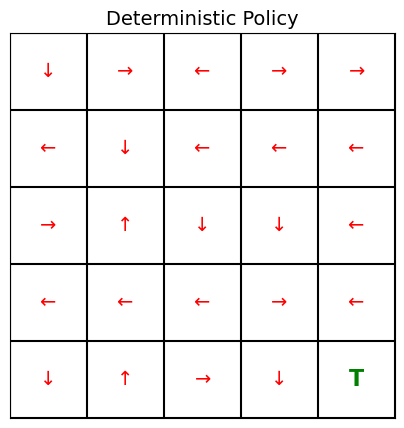

In [34]:
# Create environment
env = GridWorld(height=5, width=5, start=(0, 0), goal=(4, 4))

# Random stochastic policy
stochastic_policy = env.random_policy()

# Convert to deterministic
policy, rewards = env.deterministic_policy(stochastic_policy)

# Show the arrows of the policy
env.visualise_policy(policy, title="Deterministic Policy")


# Visualise the Random policy

(0, 0)


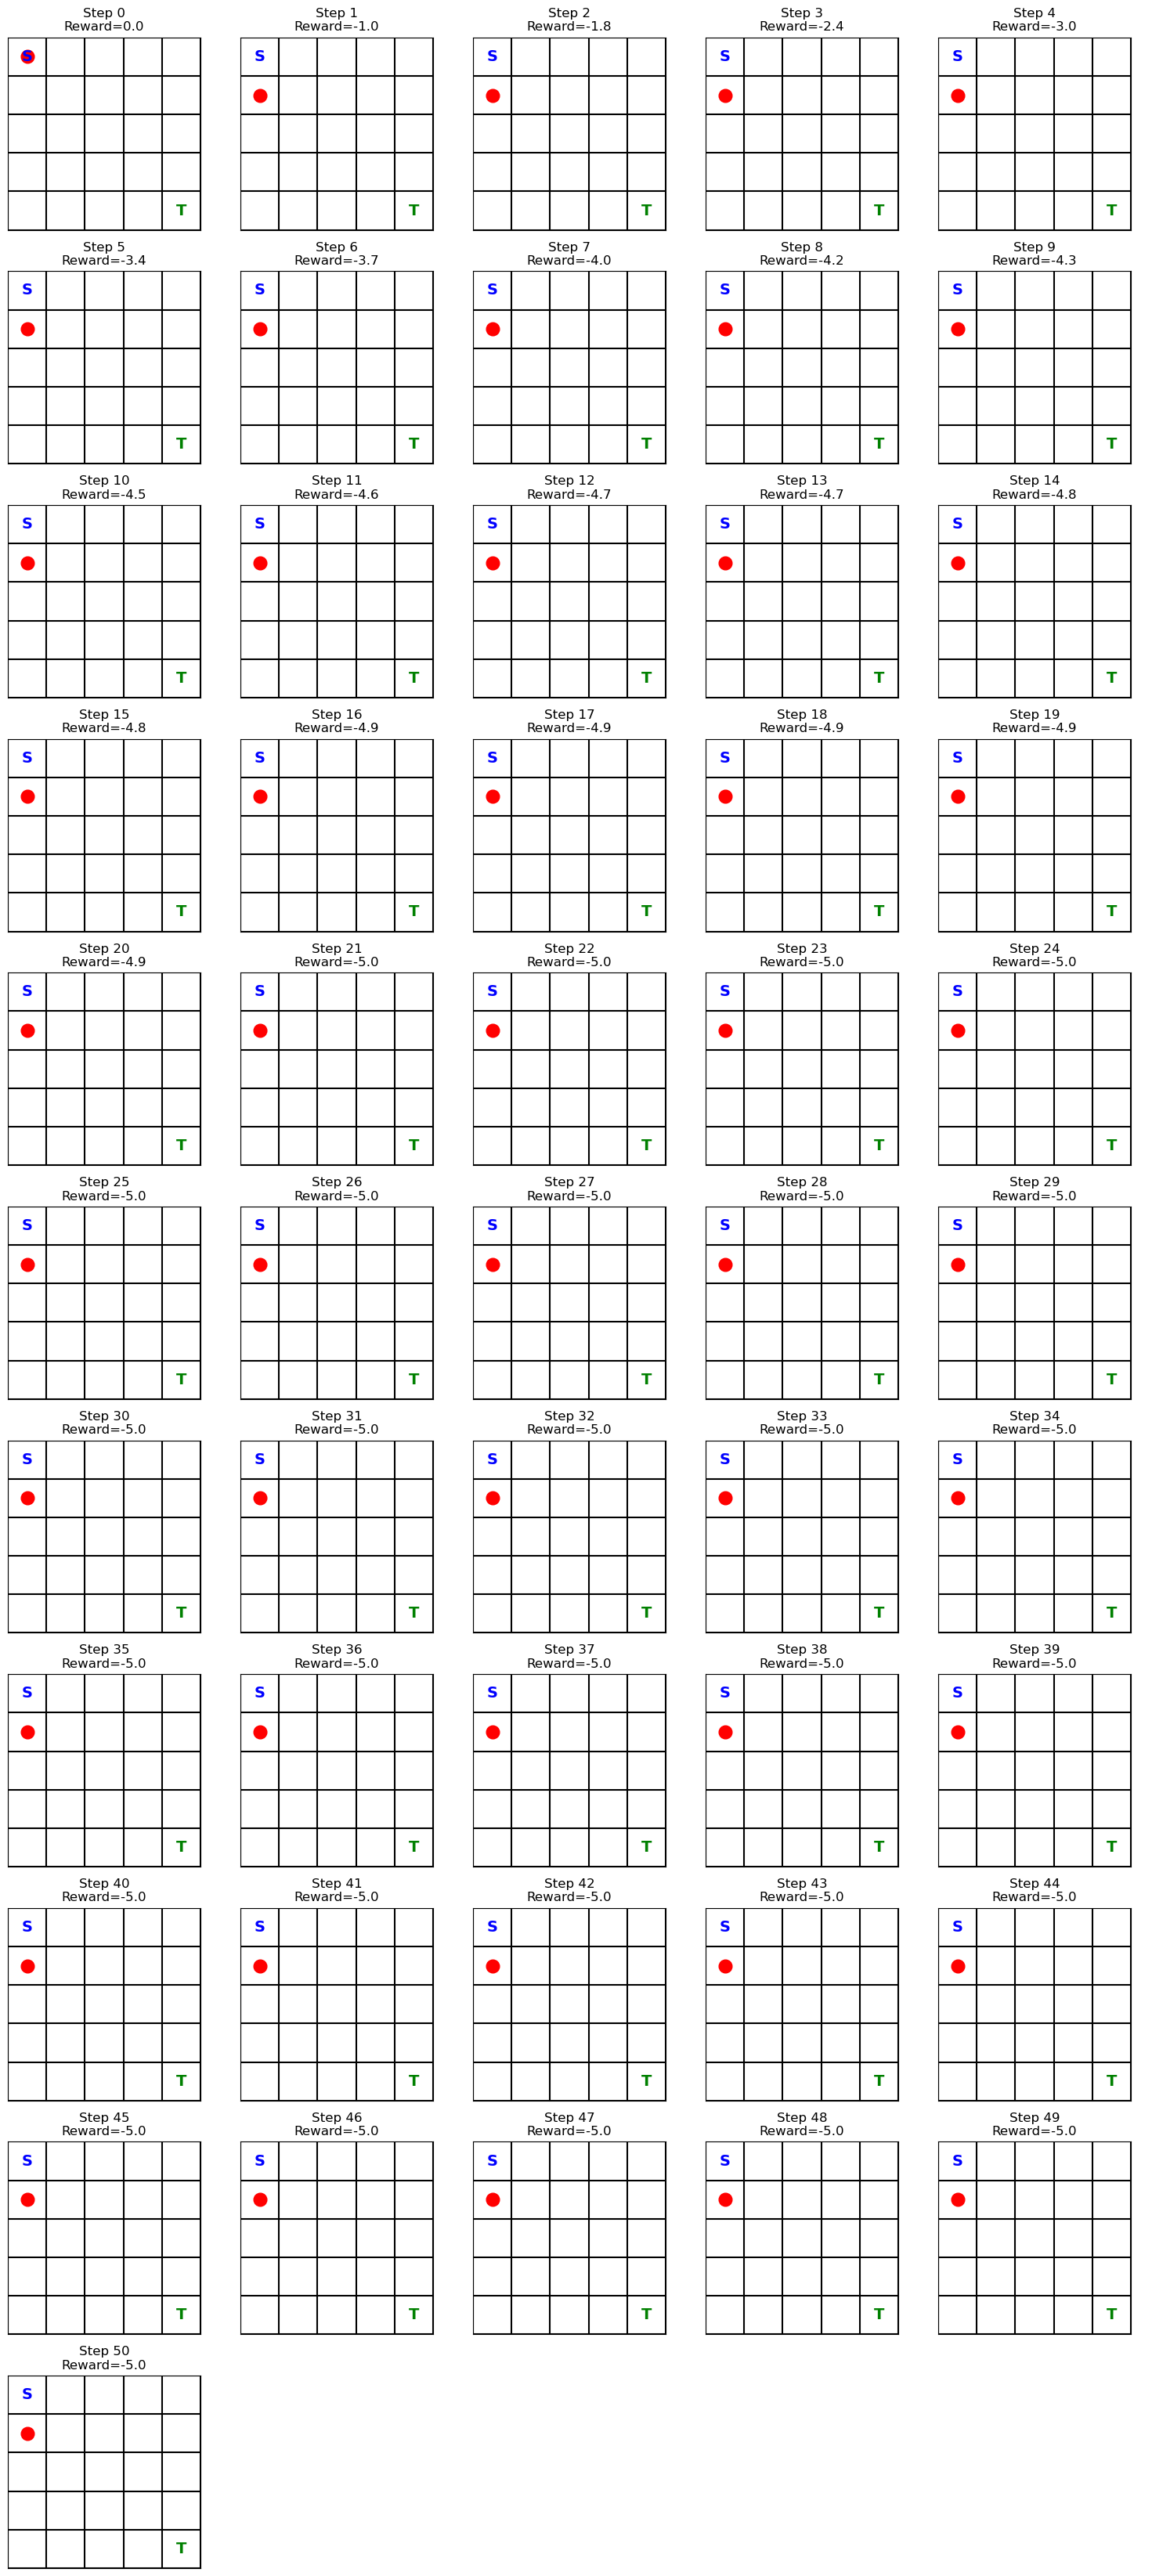

In [35]:
print(f"{env.start}")
env.visualise_episode(policy)


# Test the Algo

In [36]:
# test the value iteration
V_vi , policy_vi = env.value_iteration()

In [37]:
print(V_vi)

{0: -2.9028480000000005, 1: -2.3785600000000002, 2: -1.7231999999999998, 3: -0.9039999999999997, 4: 0.12000000000000033, 5: -2.3785600000000002, 6: -1.7231999999999998, 7: -0.9039999999999997, 8: 0.12000000000000033, 9: 1.4000000000000004, 10: -1.7231999999999998, 11: -0.9039999999999997, 12: 0.12000000000000033, 13: 1.4000000000000004, 14: 3.0, 15: -0.9039999999999997, 16: 0.12000000000000033, 17: 1.4000000000000004, 18: 3.0, 19: 5.0, 20: 0.12000000000000033, 21: 1.4000000000000004, 22: 3.0, 23: 5.0, 24: 0.0}


In [38]:
env.visualize_values_matrix(V_vi)


array([[-2.902848, -2.37856 , -1.7232  , -0.904   ,  0.12    ],
       [-2.37856 , -1.7232  , -0.904   ,  0.12    ,  1.4     ],
       [-1.7232  , -0.904   ,  0.12    ,  1.4     ,  3.      ],
       [-0.904   ,  0.12    ,  1.4     ,  3.      ,  5.      ],
       [ 0.12    ,  1.4     ,  3.      ,  5.      ,  0.      ]])

In [39]:
# ACTIONS = {
#         0: (-1, 0),  # UP
#         1: (1, 0),   # DOWN
#         2: (0, -1),  # LEFT
#         3: (0, 1)    # RIGHT
#     }

In [40]:
print(policy_vi)

{0: {0: 0.0, 1: 1.0, 2: 0.0, 3: 1.0}, 1: {0: 0.0, 1: 1.0, 2: 0.0, 3: 1.0}, 2: {0: 0.0, 1: 1.0, 2: 0.0, 3: 1.0}, 3: {0: 0.0, 1: 1.0, 2: 0.0, 3: 1.0}, 4: {0: 0.0, 1: 1.0, 2: 0.0, 3: 0.0}, 5: {0: 0.0, 1: 1.0, 2: 0.0, 3: 1.0}, 6: {0: 0.0, 1: 1.0, 2: 0.0, 3: 1.0}, 7: {0: 0.0, 1: 1.0, 2: 0.0, 3: 1.0}, 8: {0: 0.0, 1: 1.0, 2: 0.0, 3: 1.0}, 9: {0: 0.0, 1: 1.0, 2: 0.0, 3: 0.0}, 10: {0: 0.0, 1: 1.0, 2: 0.0, 3: 1.0}, 11: {0: 0.0, 1: 1.0, 2: 0.0, 3: 1.0}, 12: {0: 0.0, 1: 1.0, 2: 0.0, 3: 1.0}, 13: {0: 0.0, 1: 1.0, 2: 0.0, 3: 1.0}, 14: {0: 0.0, 1: 1.0, 2: 0.0, 3: 0.0}, 15: {0: 0.0, 1: 1.0, 2: 0.0, 3: 1.0}, 16: {0: 0.0, 1: 1.0, 2: 0.0, 3: 1.0}, 17: {0: 0.0, 1: 1.0, 2: 0.0, 3: 1.0}, 18: {0: 0.0, 1: 1.0, 2: 0.0, 3: 1.0}, 19: {0: 0.0, 1: 1.0, 2: 0.0, 3: 0.0}, 20: {0: 0.0, 1: 0.0, 2: 0.0, 3: 1.0}, 21: {0: 0.0, 1: 0.0, 2: 0.0, 3: 1.0}, 22: {0: 0.0, 1: 0.0, 2: 0.0, 3: 1.0}, 23: {0: 0.0, 1: 0.0, 2: 0.0, 3: 1.0}, 24: {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}}


In [41]:
# Test the policy ite
# test the value iteration
V_pi , policy_pi = env.policy_iteration()

In [42]:
print(V_pi)

{0: -1.5233279999999965, 1: 0.2979200000000022, 2: 0.8112000000000013, 3: 0.6320000000000008, 4: 0.12000000000000033, 5: 0.2979200000000022, 6: 1.6224000000000025, 7: 2.2640000000000016, 8: 2.040000000000001, 9: 1.4000000000000004, 10: 0.8112000000000013, 11: 2.2640000000000016, 12: 4.080000000000002, 13: 3.8000000000000007, 14: 3.0, 15: 0.6320000000000008, 16: 2.040000000000001, 17: 3.8000000000000007, 18: 6.0, 19: 5.0, 20: 0.12000000000000033, 21: 1.4000000000000004, 22: 3.0, 23: 5.0, 24: 0.0}


In [45]:
print(env.visualize_values_matrix(V_pi))

[[-1.523328  0.29792   0.8112    0.632     0.12    ]
 [ 0.29792   1.6224    2.264     2.04      1.4     ]
 [ 0.8112    2.264     4.08      3.8       3.      ]
 [ 0.632     2.04      3.8       6.        5.      ]
 [ 0.12      1.4       3.        5.        0.      ]]


In [46]:
print(policy_pi)

{0: {0: 0.0, 1: 1.0, 2: 0.0, 3: 1.0}, 1: {0: 0.0, 1: 1.0, 2: 0.0, 3: 0.0}, 2: {0: 0.0, 1: 1.0, 2: 0.0, 3: 0.0}, 3: {0: 0.0, 1: 1.0, 2: 0.0, 3: 0.0}, 4: {0: 0.0, 1: 1.0, 2: 0.0, 3: 0.0}, 5: {0: 0.0, 1: 0.0, 2: 0.0, 3: 1.0}, 6: {0: 0.0, 1: 1.0, 2: 0.0, 3: 1.0}, 7: {0: 0.0, 1: 1.0, 2: 0.0, 3: 0.0}, 8: {0: 0.0, 1: 1.0, 2: 0.0, 3: 0.0}, 9: {0: 0.0, 1: 1.0, 2: 0.0, 3: 0.0}, 10: {0: 0.0, 1: 0.0, 2: 0.0, 3: 1.0}, 11: {0: 0.0, 1: 0.0, 2: 0.0, 3: 1.0}, 12: {0: 0.0, 1: 1.0, 2: 0.0, 3: 1.0}, 13: {0: 0.0, 1: 1.0, 2: 0.0, 3: 0.0}, 14: {0: 0.0, 1: 1.0, 2: 0.0, 3: 0.0}, 15: {0: 0.0, 1: 0.0, 2: 0.0, 3: 1.0}, 16: {0: 0.0, 1: 0.0, 2: 0.0, 3: 1.0}, 17: {0: 0.0, 1: 0.0, 2: 0.0, 3: 1.0}, 18: {0: 0.0, 1: 1.0, 2: 0.0, 3: 1.0}, 19: {0: 0.0, 1: 1.0, 2: 0.0, 3: 0.0}, 20: {0: 0.0, 1: 0.0, 2: 0.0, 3: 1.0}, 21: {0: 0.0, 1: 0.0, 2: 0.0, 3: 1.0}, 22: {0: 0.0, 1: 0.0, 2: 0.0, 3: 1.0}, 23: {0: 0.0, 1: 0.0, 2: 0.0, 3: 1.0}, 24: {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}}
